In [1]:
from fractalai.model import RandomDiscreteModel
from fractalai.environment import ParallelEnvironment, AtariEnvironment
from fractalai.swarm_wave import SwarmWave
from fractalai.fractalmc import FractalMC
import time

# Let's play Pacman with a Swarm Wave!

In [68]:
name = "MsPacman-ram-v0"

n_walkers = 88 # Maximum witdh of the tree containing al the trajectories, the bigger the better
balance = 2  # Balance exploration vs exploitation

dt_mean = 4 # Apply the same action n times in average
dt_std = 2 # Repeat same action a variable number of times
min_dt = 3 # Minimum number of consecutive steps to be taken

n_samples = 750000 # Maximum number of samples allowed
reward_limit = 35000  # Stop the sampling when this score is reached

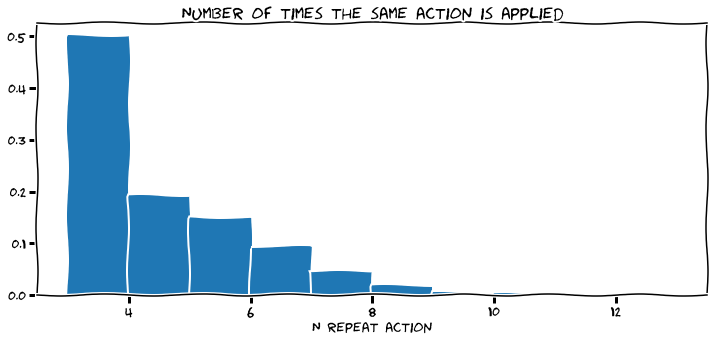

In [83]:

abs_rnd = np.abs(np.random.normal(loc=dt_mean, scale=dt_std, size=100000))
dt = np.maximum(min_dt, abs_rnd).astype(int)
with plt.xkcd():
    plt.figure(figsize=(12,5))
    _ = plt.hist(dt, density=True)
    plt.title("Number of times the same action is applied")
    #plt.grid()
    _ = plt.xlabel("N repeat action")

In [ ]:
save_data = True # Save the data generated
prune_tree = True
skip_frames = 0  # Number of frames to skip at the beginning
render_every = 10  # print statistics every n iterations.

In [3]:
env = ParallelEnvironment(name=name,env_class=AtariEnvironment,
                          blocking=False, n_workers=8)  # We will play an Atari game
model = RandomDiscreteModel(n_actions=env.n_actions) # The Agent will take discrete actions at random

/usr/local/lib/python3.6/dist-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [4]:
sw = SwarmWave(model=model, env=env, n_walkers=n_walkers, reward_limit=reward_limit, samples_limit=n_samples,
                  render_every=render_every, balance=balance, save_data=save_data,
                  dt_mean=dt_mean, dt_std=dt_std, accumulate_rewards=True, min_dt=min_dt,
                  prune_tree=prune_tree, can_win=False)

In [5]:
%%time
sw.run_swarm(print_swarm=True)

Environment: MsPacman-ram-v0 | Walkers: 88 | Deaths: 88 | data_size 104
Total samples: 692509 Progress: 92.33%
Reward: mean 31341.00 | Dispersion: 0.00 | max 31341.00 | min 31341.00 | std 0.00
Episode length: mean 8463.65 | Dispersion 7.00 | max 8469.00 | min 8462.00 | std 1.66
Dt: mean 4.08 | Dispersion: 6.00 | max 9.00 | min 3.00 | std 1.46
Status: All the walkers died.
Efficiency 0.31%
Generated 2136 Examples | 324.21 samples per example.

CPU times: user 13.1 s, sys: 231 ms, total: 13.3 s
Wall time: 1min 17s


In [6]:
@Miau_db

SyntaxError: unexpected EOF while parsing (<ipython-input-6-5aa5c7a42852>, line 1)

In [84]:
sw.render_game(sleep=0.008)

## Statistics about the data generated

In [ ]:
sw._n_samples_done

In [7]:
# Copy paste from cell above
total_saples = sw._n_samples_done
mean_samples = sw.times.mean() # Mean episode length
score = sw.rewards.max()
time = 60 + 17

score_human = 15693
fps_atari = 20

mean_fps_fai = (mean_samples / time) 
mean_fps_rel = mean_fps_fai/ fps_atari

samples_action = total_saples / mean_samples
score_ratio = score / score_human 

print("The game was sampled after {} samples, at {:.2f} fps, \n"
      "{:.2f} times faster than human gameplay. \n"
      "It achieved an score {:.2f} times better than a human playing for 2 hours.\n"
      "It took {:.2f} samples per action (per game on average).\n"
      .format(total_saples, mean_fps_fai, mean_fps_rel, score_ratio, samples_action))

The game was sampled after 692509 samples, at 109.92 fps, 
5.50 times faster than human gameplay. 
It achieved an score 2.00 times better than a human playing for 2 hours.
It took 81.82 samples per action (per game on average).



### Benchmark against other planning algorithms: UCT & p-IW

- [Planning with Pixels in (Almost) Real Time](https://arxiv.org/pdf/1801.03354.pdf)
- [Blind Search for Atari-Like Online Planning Revisited](https://www.ijcai.org/Proceedings/16/Papers/460.pdf)

In [42]:
N_cluster = 2
cluster_coef =  (64 * 2.3) / (8 * 2.8) # 64 cpus @2.3GHz M4.16xlarge vs. 8cpus @2.8GHz my laptop
plan_samples_action = 150000
ipw_score = 30785

samples_ratio = plan_samples_action / samples_action
ipw_score_ratio = score / ipw_score

ipw_fast_score = 15115.0
ipw_fast_fps = 0.5
ipw_fast_faster =  mean_fps_fai / ipw_fast_fps
ipw_fast_samples_ratio = mean_fps_fai / ipw_fast_fps * cluster_coef * N_cluster
ipw_fast_score_ratio = score / ipw_fast_score 

big_ipw_score = 23033.0
big_ipw_fps = 1 / 32
big_ipw_faster = mean_fps_fai / big_ipw_fps
big_ipw_samples_ratio = mean_fps_fai / big_ipw_fps * cluster_coef * N_cluster
big_ipw_score_ratio = score / big_ipw_score 

uct_score = 22336
uct_score_ratio = score / uct_score 




print("Efficientcy vs.p-IW at 0.5fps in a cluster:\n"
      "It a chieved and score {:.2f} times better than p-IW.\n"
      "SW is {:.2f} times faster than p-IW on a cluster of M4.16xlarge running at 0.5fps.\n"
      "SW is {:.2f} times more efficient than p-IW.\n"
      .format(ipw_fast_score_ratio, ipw_fast_faster, ipw_fast_samples_ratio))

print("Efficientcy vs. p-IW 1/32fps in a cluster:\n"
      "It a chieved and score {:.2f} times better than p-IW.\n"
      "SW is {:.2f} times faster than p-IW on a cluster of M4.16xlarge running at 1/32 fps\n"
      "SW is {:.2f} times more efficient than p-IW.\n"
      .format(big_ipw_score_ratio, big_ipw_faster, big_ipw_samples_ratio))

print("Efficiency vs. 150k p-IW:\n"
      "It a chieved and score {:.2f} times better than p-IW.\n"
      "SW is {:.2f} times more efficient than p-IW.\n"
      .format(ipw_score_ratio, samples_ratio))

print("Efficiency vs. 150k UCT:\n"
      "It a chieved and score {:.2f} times better than UCT.\n"
      "SW is {:.2f} times more efficient than UCT.\n"
      .format(uct_score_ratio, samples_ratio))

Efficientcy vs.p-IW at 0.5fps in a cluster:
It a chieved and score 2.07 times better than p-IW.
SW is 219.84 times faster than p-IW on a cluster of M4.16xlarge running at 0.5fps.
SW is 2889.26 times more efficient than p-IW.

Efficientcy vs. p-IW 1/32fps in a cluster:
It a chieved and score 1.36 times better than p-IW.
SW is 3517.36 times faster than p-IW on a cluster of M4.16xlarge running at 1/32 fps
SW is 46228.16 times more efficient than p-IW.

Efficiency vs. 150k p-IW:
It a chieved and score 1.02 times better than p-IW.
SW is 1833.26 times more efficient than p-IW.

Efficiency vs. 150k UCT:
It a chieved and score 1.40 times better than UCT.
SW is 1833.26 times more efficient than UCT.



In [51]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
columns = ["FPS", "Samples/action", "Score"]
index = ["SW", "Human", "UTC (AlphaZero)","p-IW 150k", "p-IW 0.5s", "p-IW 1/32s"]
data = [[mean_fps_fai, samples_action, score],
        [fps_atari, np.nan, score_human],
        [np.nan, plan_samples_action, uct_score],
       [np.nan, plan_samples_action, ipw_score],
       [ipw_fast_fps, ipw_fast_samples_ratio, ipw_fast_score],
       [big_ipw_fps, big_ipw_samples_ratio, big_ipw_score]]
results = pd.DataFrame(index=index, columns=columns, data=data)
results

,FPS,Samples/action,Score
SW,109.917503,81.821577,31341.0
Human,20.000000,NaN,15693.0
UTC (AlphaZero),NaN,150000.000000,22336.0
p-IW 150k,NaN,150000.000000,30785.0
p-IW 0.5s,0.500000,2889.260078,15115.0
p-IW 1/32s,0.031250,46228.161241,23033.0


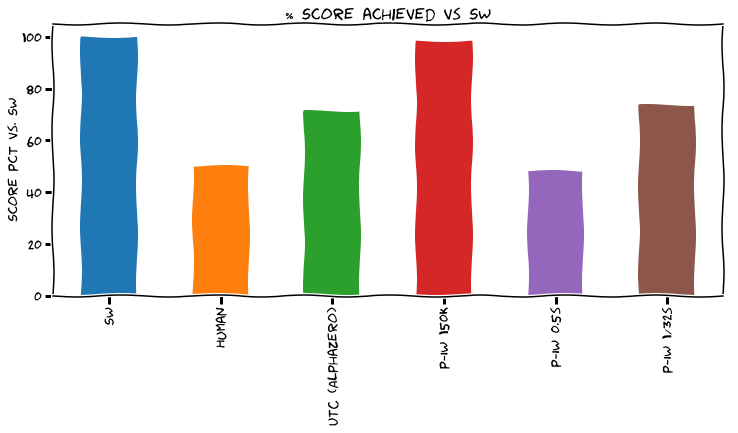

In [67]:
with plt.xkcd():
    _ = (100 * results["Score"] / results["Score"][0]).plot(kind="bar",
                                                            title="% Score achieved vs SW",
                                                            figsize=(12,5))
    plt.ylabel("Score pct vs. SW")

# Let's try FMC

In [ ]:
name = "MsPacman-ram-v0"
skip_frames = 0  # Number of frames to skip at the beginning
dt_mean = 4 # Apply the same action n times in average
dt_std = 2 # Repeat same action a variable number of times
min_dt = 4 # Minimum number of consecutive steps to be taken
n_samples = 2000 # Maximum number of samples allowed
reward_limit = 100000  # Stop the sampling when this score is reached
n_walkers = 50 # Maximum witdh of the tree containing al the trajectories
render_every = 1  # print statistics every n iterations.
balance = 2  # Balance exploration vs exploitation
time_horizon = 30 # How deep we want each cone to be on average
min_horizon = 30 # Minimum time horizon for the cone
clone_seeds = False # Clone random seeds when getting ale state. If false env is stochastic

In [ ]:
fmc_env = ParallelEnvironment(name=name, env_class=AtariEnvironment, clone_seeds=clone_seeds,
                          blocking=False, n_workers=8)  # We will play an Atari game
fmc_model = RandomDiscreteModel(n_actions=fmc_env.n_actions) # The Agent will take discrete actions at random

In [ ]:
fmc = FractalMC(model=fmc_model, env=fmc_env, max_walkers=n_walkers,
                reward_limit=reward_limit, max_samples=n_samples,
                render_every=render_every, balance=balance, time_horizon=time_horizon,
                min_horizon=min_horizon, dt_mean=dt_mean, dt_std=dt_std, accumulate_rewards=True,
                min_dt=min_dt, can_win=False, update_parameters=True)

In [ ]:
fmc.run_agent(print_swarm=False, render=True)

# Q-bert as a proof of concept

### - Create a super-human gym-like Env
### - Sample games uring [ray](https://ray.readthedocs.io/en/latest/)
### - True action inside info
### - Hack OpenAI [baselines](https://github.com/openai/baselines)!

In [ ]:
import ray
ray.init()

### Parameters for the swarm used in the hacked Env

In [ ]:
swarm_kwargs = dict(dt_mean=10,  # Apply the same action n times in average
                    dt_std=5,  # Repeat same action a variable number of times
                    min_dt=5,  # Minimum number of consecutive steps to be taken
                    samples_limit=300000,  # 200000  # Maximum number of samples allowed
                    reward_limit=5000,  # Stop the sampling when this score is reached
                    n_walkers=50,  # Maximum width of the tree containing al the trajectories
                    render_every=100,  # print statistics every n iterations.
                    balance=2,  # Balance exploration vs exploitation
                    save_data=True,  # Save the data generated
                    accumulate_rewards=True,
                    prune_tree=True)

generator_kwargs = {}

### Same interface as OpenAI baselines

In [ ]:
# requires OpenAI baslines
from fractalai.datasets.baselines import make_atari_env

env_id = "QbertNoFrameskip-v4"
num_env = 2
seed = 10
n_actors = 8
hacked_env = make_atari_env(env_id, num_env, seed, wrapper_kwargs=None, start_index=0, swarm_kwargs=swarm_kwargs,
                           generator_kwargs=generator_kwargs, n_actors=n_actors)

### Fill up the buffer of played games

In [ ]:
%%time 
obs = hacked_env.reset()

### Let's see how it plays

In [ ]:
import time
ends = [False, False]
while not ends[0]:
    observation, rewards, ends, infos = hacked_env.step("IGNORE THIS")
    
    hacked_env.render()
    time.sleep(0.025)

# Dataset generation

In [ ]:
from fractalai.datasets.mlswarm import MLWave, MLFMC
from fractalai.datasets.data_generator import DataGenerator

In [ ]:
name = "MsPacman-v0"
skip_frames = 0  # Number of frames to skip at the beginning
dt_mean = 2  # Apply the same action n times in average
dt_std = 2.5 # Repeat same action a variable number of times
min_dt = 1 # Minimum number of consecutive steps to be taken
n_samples = 100000#200000  # Maximum number of samples allowed
reward_limit = 10000  # Stop the sampling when this score is reached
n_walkers = 75  # Maximum witdh of the tree containing al the trajectories
render_every = 1  # print statistics every n iterations.
balance = 2  # Balance exploration vs exploitation
save_data = True # Save the data generated

prune_tree = True

In [ ]:
sw = MLWave(model=model, env=env, n_walkers=n_walkers, reward_limit=reward_limit, samples_limit=n_samples,
                  render_every=render_every, balance=balance, save_data=save_data,
                  dt_mean=dt_mean, dt_std=dt_std, accumulate_rewards=True, min_dt=min_dt,
                  prune_tree=prune_tree)
datagen = DataGenerator(sw)

### Save whole games into a folder

In [ ]:
%%time
n_games = 1
output_folder = "dataset"
for i in range(n_games):
    datagen.save_run(output_folder, render=True, print_swarm=False)

### Generate examples for supervised learning

In [ ]:
%%time
example_gen = datagen.example_generator()
obs, action, reward, next_obs, end = next(example_gen)

### Generate batches of examples

In [ ]:
%%time
batch_gen = datagen.batch_generator()
obs, action, reward, next_obs, end = next(batch_gen)

In [ ]:
len(reward)